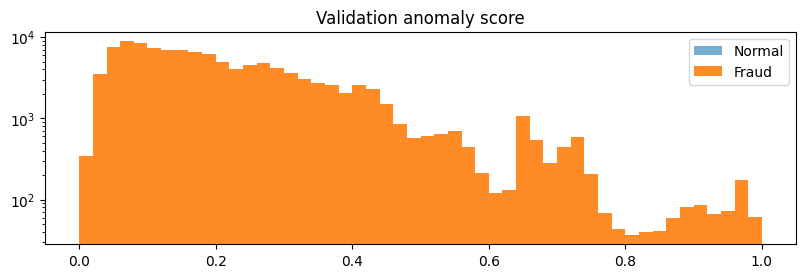

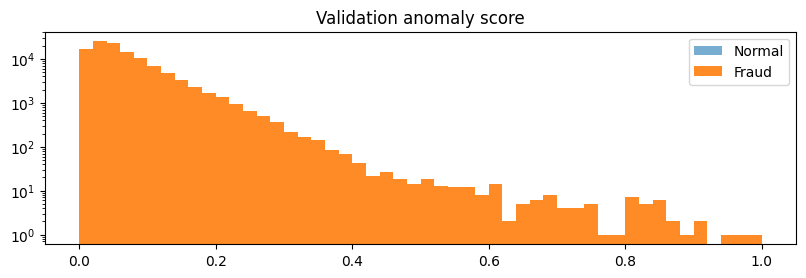

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score

import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

import tkinter as tk
from tkinter import ttk, filedialog, messagebox


# Utility: Train / Test / Validation split
def split_dataset(df, time_column=None, train_size=0.6, test_size=0.2):
    if time_column and time_column in df.columns:
        df = df.sort_values(time_column)

    n = len(df)
    train_end = int(n * train_size)
    test_end = int(n * (train_size + test_size))

    return df.iloc[:train_end], df.iloc[train_end:test_end], df.iloc[test_end:]


# Precision / Recall @ Threshold
def precision_recall_at_k(y_true, scores, threshold=0.95):
    y_pred = (scores >= threshold).astype(int)
    return (
        precision_score(y_true, y_pred, zero_division=0),
        recall_score(y_true, y_pred, zero_division=0),
        y_pred
    )


# Model descriptions
MODEL_DESCRIPTIONS = {
    "Isolation Forest": "Isolation Forest: ізолює аномалії за допомогою випадкових дерев.",
    "Autoencoder": "Autoencoder: реконструкція даних, аномалії мають високий reconstruction error.",
    "One-Class SVM": "One-Class SVM: навчає межу для нормальних транзакцій.",
    "LOF": "Local Outlier Factor: локальна щільність сусідів."
}


# Logger
class Logger:
    def __init__(self):
        self.logs = []

    def log(self, method, idx, score):
        self.logs.append({
            "method": method,
            "index": idx,
            "score": score
        })

    def reset(self):
        self.logs = []

    def get(self):
        return pd.DataFrame(self.logs)


logger = Logger()


# Fraud Detector
class FraudDetector:
    def __init__(self, df, scaler=None, progress_callback=None):
        self.df = df.copy()
        self.progress_callback = progress_callback

        self.y = df["Class"].values if "Class" in df.columns else None
        self.features = [f"V{i}" for i in range(1, 29)] + ["Amount"]
        self.X = df[self.features].values

        if scaler is None:
            self.scaler = StandardScaler()
            self.X_scaled = self.scaler.fit_transform(self.X)
        else:
            self.scaler = scaler
            self.X_scaled = self.scaler.transform(self.X)

    # ----------------------------
    def isolation_forest(self):
        model = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
        model.fit(self.X_scaled)
        scores = -model.score_samples(self.X_scaled)
        scores = (scores - scores.min()) / (scores.max() - scores.min())

        for i in np.argsort(scores)[-5:]:
            logger.log("Isolation Forest", i, scores[i])

        if self.progress_callback:
            self.progress_callback(100)

        return scores, self.y

    # ----------------------------
    def autoencoder(self):
        X_tensor = torch.tensor(self.X_scaled, dtype=torch.float32)
        loader = DataLoader(TensorDataset(X_tensor), batch_size=64, shuffle=True)

        class AE(nn.Module):
            def __init__(self, dim):
                super().__init__()
                self.enc = nn.Sequential(nn.Linear(dim, 32), nn.ReLU(), nn.Linear(32, 8))
                self.dec = nn.Sequential(nn.Linear(8, 32), nn.ReLU(), nn.Linear(32, dim))

            def forward(self, x):
                return self.dec(self.enc(x))

        model = AE(X_tensor.shape[1])
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = nn.MSELoss()

        epochs = 10
        steps = epochs * len(loader)
        step = 0

        for _ in range(epochs):
            for (batch,) in loader:
                opt.zero_grad()
                loss = loss_fn(model(batch), batch)
                loss.backward()
                opt.step()
                step += 1
                if self.progress_callback:
                    self.progress_callback(int(step / steps * 100))

        with torch.no_grad():
            recon = model(X_tensor)
            scores = torch.mean((X_tensor - recon) ** 2, dim=1).numpy()

        scores = (scores - scores.min()) / (scores.max() - scores.min())

        for i in np.argsort(scores)[-5:]:
            logger.log("Autoencoder", i, scores[i])

        return scores, self.y

    # ----------------------------
    def one_class_svm(self):
        model = OneClassSVM(nu=0.01, kernel="rbf", gamma="scale")
        model.fit(self.X_scaled)
        scores = -model.decision_function(self.X_scaled)
        scores = (scores - scores.min()) / (scores.max() - scores.min())

        for i in np.argsort(scores)[-5:]:
            logger.log("One-Class SVM", i, scores[i])

        return scores, self.y

    # ----------------------------
    def lof(self):
        model = LocalOutlierFactor(n_neighbors=20, novelty=True)
        model.fit(self.X_scaled)
        scores = -model.decision_function(self.X_scaled)
        scores = (scores - scores.min()) / (scores.max() - scores.min())

        for i in np.argsort(scores)[-5:]:
            logger.log("LOF", i, scores[i])

        return scores, self.y


# GUI
class App:
    def __init__(self, root):
        self.root = root
        root.title("Система виявлення шахрайських транзакцій")
        root.geometry("950x820")

        self.df = None

        tk.Button(root, text="📂 Завантажити CSV", command=self.load_csv).pack(pady=5)

        self.mode = tk.StringVar(value="train")
        ttk.Radiobutton(root, text="🧠 Training", variable=self.mode, value="train").pack()
        ttk.Radiobutton(root, text="🧪 Test / Validation", variable=self.mode, value="test").pack()

        self.method = ttk.Combobox(
            root,
            values=list(MODEL_DESCRIPTIONS.keys()),
            state="readonly",
            width=30
        )
        self.method.set("Isolation Forest")
        self.method.pack(pady=5)

        tk.Label(root, text="Threshold").pack()
        self.threshold = tk.DoubleVar(value=0.95)
        tk.Entry(root, textvariable=self.threshold, width=8).pack()

        tk.Button(root, text="▶ Запустити", command=self.run).pack(pady=5)

        self.progress = ttk.Progressbar(root, length=600)
        self.progress.pack(pady=5)

        self.output = tk.Text(root, height=14, width=110)
        self.output.pack(pady=5)

        self.figure_frame = tk.Frame(root)
        self.figure_frame.pack(fill="both", expand=True)

    # ----------------------------
    def load_csv(self):
        path = filedialog.askopenfilename(filetypes=[("CSV", "*.csv")])
        if path:
            self.df = pd.read_csv(path)
            messagebox.showinfo("OK", "Датасет завантажено")

    def update_progress(self, v):
        self.progress["value"] = v
        self.root.update_idletasks()

    # ----------------------------
    def run_model(self, detector, name):
        if name == "Isolation Forest":
            return detector.isolation_forest()
        if name == "Autoencoder":
            return detector.autoencoder()
        if name == "One-Class SVM":
            return detector.one_class_svm()
        if name == "LOF":
            return detector.lof()

    # ----------------------------
    def run(self):
        if self.df is None:
            messagebox.showerror("Помилка", "Завантажте датасет")
            return

        logger.reset()
        self.progress["value"] = 0
        self.output.delete("1.0", tk.END)

        df_train, df_test, df_val = split_dataset(
            self.df,
            time_column="Time" if "Time" in self.df.columns else None
        )

        model_name = self.method.get()
        mode = self.mode.get()
        threshold = self.threshold.get()

        self.output.insert(tk.END, f"Режим: {mode.upper()}\n")
        self.output.insert(tk.END, f"Модель: {model_name}\n")
        self.output.insert(tk.END, MODEL_DESCRIPTIONS[model_name] + "\n\n")

        # ===== TRAIN =====
        train_detector = FraudDetector(df_train, progress_callback=self.update_progress)
        self.run_model(train_detector, model_name)

        if mode == "train":
            self.output.insert(tk.END, "✅ Навчання завершено (без оцінки якості)\n")
            return

        # ===== VALIDATION =====
        val_detector = FraudDetector(df_val, scaler=train_detector.scaler)
        scores, y = self.run_model(val_detector, model_name)

        p, r, _ = precision_recall_at_k(y, scores, threshold)

        self.output.insert(tk.END, f"Validation Precision: {p:.4f}\n")
        self.output.insert(tk.END, f"Validation Recall: {r:.4f}\n")

        # ===== Plot =====
        for w in self.figure_frame.winfo_children():
            w.destroy()

        fig, ax = plt.subplots(figsize=(8, 5))
        ax.hist(scores[y == 0], bins=50, alpha=0.6, label="Normal")
        ax.hist(scores[y == 1], bins=50, alpha=0.9, label="Fraud")
        ax.set_yscale("log")
        ax.legend()
        ax.set_title("Validation anomaly score")

        canvas = FigureCanvasTkAgg(fig, master=self.figure_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill="both", expand=True)

        #Logs
        self.output.insert(tk.END, "\nTop-5 аномалій:\n")
        self.output.insert(tk.END, logger.get().head().to_string(index=False))


# Run
root = tk.Tk()
app = App(root)
root.mainloop()